In [1]:
%cd /home/x_amime/x_amime/projects/an_explanation_model/

/proj/azizpour-group/users/x_amime/projects/an_explanation_model


/home/x_amime/.conda/envs/xlab/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import partial

from source.project_manager import (
    merge_experiment_metadata,
    load_experiment_metadata,
    delete_experiment_data,
    check_file_exists,
)
from commands.experiment_8 import (
    dataset_dir,
    input_shape,
)

save_metadata_dir = "outputs/metadata/"
save_output_dir = "outputs/raw_data/experiment_8_*"

from source.data_manager import (
    preprocess_masks,
    plot_masks,
    minmax_normalize,
    sum_channels,
    symmetric_minmax_normalize,
    single_query_imagenet,
    save_axis,
)
from source.labels import IMAGENET_LABELS

imshow_args = {"cmap": "jet"}

query_imagenet = partial(
    single_query_imagenet, dataset_dir=dataset_dir, input_shape=input_shape
)

# run once
# merged_experiment_metadata = merge_experiment_metadata(save_metadata_dir=save_metadata_dir, glob_path="experiment_8_*/merged_*.csv")

2024-01-19 09:10:46.087758: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 09:10:48.227883: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/x_amime/.conda/envs/xlab/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
project_metadata = load_experiment_metadata(save_metadata_dir, glob_path="merged_*.csv")
print(project_metadata.columns)
project_metadata = project_metadata.dropna().set_index(
    [
        "image_index",
        "alpha_mask_value",
    ]
).sort_index()
print(project_metadata.shape)

/proj/azizpour-group/users/x_amime/projects/an_explanation_model/source/project_manager.py:40: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(metadata_path, index_col=False)


Index(['time_to_compute', 'batch_index', 'monitored_statistic_change',
       'path_prefix', 'data_path', 'stream_name', 'stream_statistic',
       'alpha_mask_type', 'alpha_mask_value', 'baseline_mask_type',
       'projection_type', 'projection_distribution', 'projection_top_k',
       'projection_index', 'label', 'architecture', 'method', 'output_layer',
       'dataset', 'image_index', 'image_path', 'input_shape', 'num_classes',
       'seed', 'batch_size', 'max_batches', 'min_change',
       'metadata_file_path'],
      dtype='object')
(547344, 26)


In [5]:
vc = project_metadata.index.value_counts()
print(vc)
print(len(vc))
image_indices = project_metadata.index.get_level_values("image_index").unique()

image_index  alpha_mask_value
0.0          0.0                 1
33392.0      1.0                 1
33394.0      0.2                 1
             0.1                 1
             0.0                 1
                                ..
16716.0      0.1                 1
             0.0                 1
16715.0      1.0                 1
             0.9                 1
49999.0      1.0                 1
Name: count, Length: 547344, dtype: int64
547344


In [6]:
frequencies = project_metadata.index.get_level_values("alpha_mask_value").unique()
frequencies

Index([               0.0,                0.1,                0.2,
                      0.3,                0.4,                0.5,
       0.6000000000000001, 0.7000000000000001,                0.8,
                      0.9,                1.0],
      dtype='float64', name='alpha_mask_value')

In [7]:
preds_temp = project_metadata["data_path"].apply(lambda y: np.load(y))

In [ ]:
temp = preds_temp.apply(lambda x: np.argmax(x))
temp.name = "preds"
temp = pd.concat([temp, project_metadata["label"]], axis=1)
temp = (
    temp.apply(lambda x: x["preds"] == x["label"], axis=1)
    .groupby("alpha_mask_value")
    .mean()
)
temp.plot()

In [45]:
temp.name = "Accuracy"
temp.to_csv("outputs/processed/accuracyatnoise.csv")

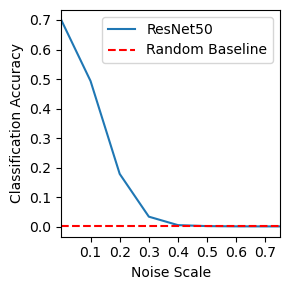

In [17]:
temp = pd.read_csv("outputs/processed/accuracyatnoise.csv")
plt.figure(figsize=(3, 3))
plt.plot(temp["alpha_mask_value"], temp["Accuracy"], label="ResNet50")
plt.xlabel("Noise Scale")
plt.xlim(0, 0.75)
plt.xticks([0.1, 0.2, 0.3 ,0.4, 0.5, 0.6, 0.7])
plt.ylabel("Classification Accuracy")
plt.hlines(0.001, 0, 1, linestyles="dashed", colors="red", label="Random Baseline")
plt.tight_layout()
plt.legend()
plt.savefig("outputs/figures/accuracyatnoise.pdf")

In [11]:
temp = preds_temp.apply(lambda x: -np.sum(x * np.exp(x)))
temp.name = "entropy"
temp = temp.groupby("alpha_mask_value").mean()

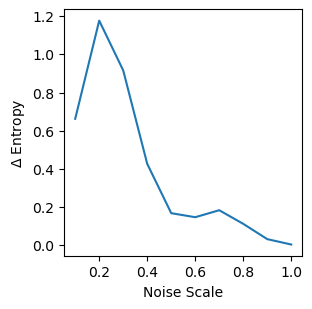

In [26]:
plt.figure(figsize=(3, 3))
delta_entropy = temp.diff()
delta_entropy = delta_entropy.dropna()
delta_entropy.to_csv("outputs/processed/delta_entropy.csv")
plt.plot(delta_entropy.index, delta_entropy)
plt.tight_layout()
plt.xlabel("Noise Scale")
plt.ylabel(r"$\Delta$ Entropy")
plt.savefig("outputs/figures/delta_entropy.pdf")

In [29]:
temp2

,alpha_mask_value,entropy
0,0.1,0.662645
1,0.2,1.176966
2,0.3,0.916214
3,0.4,0.426577
4,0.5,0.168109
5,0.6,0.147022
6,0.7,0.183619
7,0.8,0.112199
8,0.9,0.032145
9,1.0,0.003867


/tmp/ipykernel_2077100/2005047399.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/tmp/ipykernel_2077100/2005047399.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


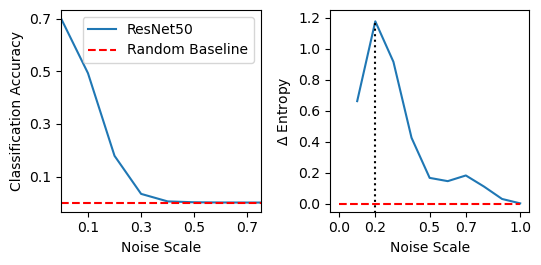

In [40]:
temp1 = pd.read_csv("outputs/processed/accuracyatnoise.csv")
temp2 = pd.read_csv("outputs/processed/delta_entropy.csv")
u=5.5
plt.subplots(figsize=(u, u/2))
plt.subplot(1, 2, 1)
plt.plot(temp1["alpha_mask_value"], temp1["Accuracy"], label="ResNet50")
plt.xlabel("Noise Scale")
plt.xlim(0, 0.75)
plt.xticks([0.1, 0.3, 0.5, 0.7])
plt.yticks([0.1, 0.3, 0.5, .7])
plt.ylabel("Classification Accuracy")
plt.hlines(0.001, 0, 1, linestyles="dashed", colors="red", label="Random Baseline")
plt.tight_layout()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(temp2["alpha_mask_value"], temp2["entropy"], label="ResNet50")
plt.xlabel("Noise Scale")
plt.xticks([0.0, 0.2, 0.5,0.7, 1.0])
plt.ylim(-0.05, 1.25)
plt.vlines(0.2, -0.2, 1.17, linestyles=":", colors="black", label="Critical Frequency Band")
plt.ylabel(r"$\Delta$ Entropy")
plt.hlines(0, 0, 1, linestyles="dashed", colors="red", label="Random Baseline")
plt.tight_layout()
# plt.legend()
plt.savefig("outputs/figures/accuracy_entropy_at_noise.pdf")